In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import SimpleITK as sitk
import sys
sys.path.append('..')
from model_utils import tfrecord_utils as tfrec

from skimage.transform import resize
import tensorflow as tf

In [2]:
def itensity_normalize_one_volume(volume,feature_range=(-1.0,1.0)):
    """
    normalize the itensity of an nd volume based on the mean and std of nonzeor region
    inputs:
        volume: the input nd volume
    outputs:
        out: the normalized nd volume
    """
    
    pixels = volume[volume > 0]
    mean = pixels.mean()
    std  = pixels.std()
    out = (volume - mean)/std
    #out_random = np.random.normal(0, 1, size = volume.shape)
    #out[volume == 0] = out_random[volume == 0]
    
    volume_std = (volume - volume.min()) / float(volume.max() - volume.min())
    return volume_std*(feature_range[1]-feature_range[0]) + feature_range[0]

In [8]:
data_dir = "/media/harrison/ShortTerm/Users/HarrisonG/research/isles/"

In [10]:
datA_file = os.path.join(data_dir,
    'training/training_1/VSD.Brain.XX.O.MR_ADC.128020/VSD.Brain.XX.O.MR_ADC.128020.nii')
inputImage = nib.load(datA_file)
nda = inputImage.get_data()
print(nda.shape)

(192, 192, 19)


In [12]:
datA_file = os.path.join(data_dir,
    'training/training_1/VSD.Brain.XX.O.MR_MTT.127014/VSD.Brain.XX.O.MR_MTT.127014.nii')
inputImage = nib.load(datA_file)
nda = inputImage.get_data()
print(nda.shape)

(192, 192, 19)


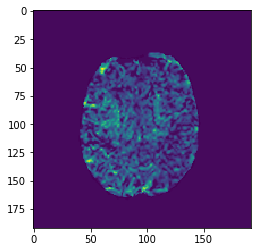

In [13]:
plt.imshow(np.rot90(nda[:,:,11],3))

In [14]:
datA_file = os.path.join(data_dir,
'training/training_1/VSD.Brain.XX.O.OT.128050/VSD.Brain.XX.O.OT.128050.nii')
inputImage = nib.load(datA_file)
nda = inputImage.get_data()
print(nda.shape)

(192, 192, 19)


In [15]:
def slice_image(img_data,patch_size=128):
    img_data = np.rot90(img_data,3)
    sliced = img_data[:,~np.all(img_data == 0, axis=(0,2)),:]
    sliced = sliced[~np.all(sliced == 0, axis=(1,2)),:,:]
    sliced = sliced[:,:,~np.all(sliced == 0, axis=(0,1))]
    
    #resize the image to 128,x,128
    x = tf.placeholder(tf.float32,sliced.shape)
   # resized_along_depth = resize_by_axis(x,patch_size,sliced.shape[1],2, True)
   # resized_along_width = resize_by_axis(resized_along_depth,patch_size,patch_size,1,True)
    resized_along_width = resize_by_axis(x,patch_size,patch_size,2,True)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    with tf.Session(config=config) as sess:
        resized = sess.run(resized_along_width,feed_dict={x:sliced})
    # normalise the image
    sliced = itensity_normalize_one_volume(resized)
    
    """
    padded = np.pad(sliced,((0,patch_size-sliced.shape[0]),
               (0,patch_size-sliced.shape[1]),
               (0,patch_size-sliced.shape[2])),
                mode='constant',
                constant_values=sliced.min())
    """
    return sliced, sliced.shape

In [16]:
def resize_by_axis(image, dim_1, dim_2, ax, is_grayscale):

    resized_list = []

    if is_grayscale:
        unstack_img_depth_list = [tf.expand_dims(x,2) for x in tf.unstack(image, axis = ax)]
        for i in unstack_img_depth_list:
            resized_list.append(tf.image.resize_images(i, [dim_1, dim_2],method=0))
        stack_img = tf.squeeze(tf.stack(resized_list, axis=ax))
        #print(stack_img.get_shape())

    else:
        unstack_img_depth_list = tf.unstack(image, axis = ax)
        for i in unstack_img_depth_list:
            resized_list.append(tf.image.resize_images(i, [dim_1, dim_2],method=0))
        stack_img = tf.stack(resized_list, axis=ax)

    return stack_img

In [17]:
#dirs = ['/media/harrison/ShortTerm/Users/HarrisonG/research/rich_data/data/']

dirs = [os.path.join(data_dir,'training/')]
data_files = []
for root in dirs:
    for path, subdirs, files in os.walk(root):
        for name in files:
            if '.nii' in name and '4DPWI' not in name and 'OT' not in name:
                data_files.append(os.path.join(path, name))

In [18]:
feature_list =  ['data','x_shape','y_shape','z_shape']
data_list = ['float','int','int','int']

In [23]:
#for ele in list(patient_no):
#    matching = [s for s in data_files if ele in s.split('/')[5]]
for i in data_files:
    #t1_file = [s for i in matching if 'T1c' in i]
    #inputImage = sitk.ReadImage(t1_file[0])
    #img_data = sitk.GetArrayFromImage(inputImage)
    #non_zero_coronal_index = ~np.all(img_data == 0, axis=(0,2))
    # get the patient number
    ele = i.split('/')[9].split('_')[1]
    inputImage = nib.load(i)
    img_data = inputImage.get_data()

    #sliced = img_data[:,non_zero_coronal_index,:]

    normed_image,shape = slice_image(img_data)
    image = np.transpose(normed_image,(2,0,1))[1:]
    shape = image.shape
    modality = i.split('.')[4]
    #if 'LG' in i:
    file_name = ele+'_'+modality
    print(file_name)
        #else:
        #    file_name = ele+'_'+modality+'HG'
        #for j in range(shape[0]):
    data_array = [np.reshape(image,(shape[0],-1)),
                     range(shape[0]),[shape[1]]*shape[0],[shape[2]]*shape[0]]
    tfrec.write_tfrecord(file_name, data_array,feature_list,data_list,
                                 'data/isles_coronal/'+modality+'/')

30_MR_ADC
30_MR_MTT
30_MR_rCBF
30_MR_rCBV
30_MR_Tmax
30_MR_TTP
1_MR_ADC
1_MR_MTT
1_MR_rCBF
1_MR_rCBV
1_MR_Tmax
1_MR_TTP
10_MR_ADC
10_MR_MTT
10_MR_rCBF
10_MR_rCBV
10_MR_Tmax
10_MR_TTP
11_MR_ADC
11_MR_MTT
11_MR_rCBF
11_MR_rCBV
11_MR_Tmax
11_MR_TTP
12_MR_ADC
12_MR_MTT
12_MR_rCBF
12_MR_rCBV
12_MR_Tmax
12_MR_TTP
13_MR_ADC
13_MR_MTT
13_MR_rCBF
13_MR_rCBV
13_MR_Tmax
13_MR_TTP
14_MR_ADC
14_MR_MTT
14_MR_rCBF
14_MR_rCBV
14_MR_Tmax
14_MR_TTP
15_MR_ADC
15_MR_MTT
15_MR_rCBF
15_MR_rCBV
15_MR_Tmax
15_MR_TTP
16_MR_ADC
16_MR_MTT
16_MR_rCBF
16_MR_rCBV
16_MR_Tmax
16_MR_TTP
18_MR_ADC
18_MR_MTT
18_MR_rCBF
18_MR_rCBV
18_MR_Tmax
18_MR_TTP
19_MR_ADC
19_MR_MTT
19_MR_rCBF
19_MR_rCBV
19_MR_Tmax
19_MR_TTP
2_MR_ADC
2_MR_MTT
2_MR_rCBF
2_MR_rCBV
2_MR_Tmax
2_MR_TTP
20_MR_ADC
20_MR_MTT
20_MR_rCBF
20_MR_rCBV
20_MR_Tmax
20_MR_TTP
21_MR_ADC
21_MR_MTT
21_MR_rCBF
21_MR_rCBV
21_MR_Tmax
21_MR_TTP
22_MR_ADC
22_MR_MTT
22_MR_rCBF
22_MR_rCBV
22_MR_Tmax
22_MR_TTP
23_MR_ADC
23_MR_MTT
23_MR_rCBF
23_MR_rCBV
23_MR_Tmax
23_MR_TTP
24_M

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


45_MR_rCBF
45_MR_rCBV
45_MR_Tmax
45_MR_TTP
46_MR_ADC
46_MR_MTT
46_MR_rCBF
46_MR_rCBV
46_MR_Tmax
46_MR_TTP
47_MR_ADC
47_MR_MTT
47_MR_rCBF
47_MR_rCBV
47_MR_Tmax
47_MR_TTP
48_MR_ADC
48_MR_MTT
48_MR_rCBF
48_MR_rCBV
48_MR_Tmax
48_MR_TTP
5_MR_ADC
5_MR_MTT
5_MR_rCBF
5_MR_rCBV
5_MR_Tmax
5_MR_TTP
6_MR_ADC
6_MR_MTT
6_MR_rCBF
6_MR_rCBV
6_MR_Tmax
6_MR_TTP
7_MR_ADC
7_MR_MTT
7_MR_rCBF
7_MR_rCBV
7_MR_Tmax
7_MR_TTP
8_MR_ADC
8_MR_MTT
8_MR_rCBF
8_MR_rCBV
8_MR_Tmax
8_MR_TTP
9_MR_ADC
9_MR_MTT
9_MR_rCBF
9_MR_rCBV
9_MR_Tmax
9_MR_TTP


ImageFileError: Cannot work out file type of "/media/harrison/ShortTerm/Users/HarrisonG/research/isles/training/__MACOSX/training_1/VSD.Brain.XX.O.MR_ADC.128020/._VSD.Brain.XX.O.MR_ADC.128020.nii"

In [24]:
parser_fn = lambda x: tfrec.tfrecord_parser(x,feature_list,data_list,128*128)
iterator,iterator_next,filename_ph,batch_ph = tfrec.create_tfrecord_queue(parser_fn,n_epochs=None)

In [25]:
import tensorflow as tf
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [26]:
#dirs = ['/media/harrison/ShortTerm/Users/HarrisonG/research/mnist_cycle/data/mri_saggital/']
dirs = ['data/isles_coronal/MR_rCBV/']
tfrecord = []
for root in dirs:
    for path, subdirs, files in os.walk(root):
        for name in files:
            if '.tfrecords' in name:
                tfrecord.append(os.path.join(path, name))

In [27]:
for ele in tfrecord:
    try:
        sess.run(iterator.initializer,feed_dict={filename_ph:[ele],
                                                batch_ph:2})
        test = sess.run(iterator_next)
    except Exception as e: 
        print(ele)
        print(e)

In [34]:
# split the dataset into training and test and paired
patient_set = set()
for ele in tfrecord:
    number = ele.split('/')[3].split('_')[0]
    patient_set.add(number)

In [45]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(list(patient_set),test_size=0.2,random_state=42)
train, train_paired = train_test_split(train,test_size=0.2,random_state=42)

In [49]:
ele.split('/')

['data', 'isles_coronal', 'MR_rCBV', '9_MR_rCBV.tfrecords']

In [53]:
dirs = ['data/isles_coronal/MR_ADC/',
        'data/isles_coronal/MR_MTT/',
        'data/isles_coronal/MR_rCBV/',
       'data/isles_coronal/MR_rCBF/',
       'data/isles_coronal/MR_Tmax/',
       'data/isles_coronal/MR_TTP/',]

for root in dirs:
    tfrecord = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if '.tfrecords' in name:
                tfrecord.append(os.path.join(path, name))
    for ele in tfrecord:
        number = ele.split('/')[3].split('_')[0]
        if number in train:
            directory = os.path.join(root,'train/')
        elif number in train_paired:
            directory = os.path.join(root,'train_paired/')
        elif number in test:
            directory = os.path.join(root,'test/')
        # check if the dir exists   
        if not os.path.exists(directory):
            os.makedirs(directory)
        # move the file
        print(os.path.join(directory,ele.split('/')[-1]))
        os.rename(ele, os.path.join(directory,ele.split('/')[-1]))

data/isles_coronal/MR_ADC/test/27_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/28_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/2_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/test/30_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/test/31_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/32_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train_paired/33_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/35_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/test/36_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/37_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/38_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/test/39_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train_paired/40_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/41_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/42_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/43_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/44_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/test/45_MR_ADC.tfrecords
data/isles_coronal/MR_ADC/train/46_MR_ADC.tfrecords
data/